# Detectron2: Inference with pre-trained model

## Install detectron2

> **Important**: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md). This notebook includes only what's necessary to run in Colab.

In [2]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

  Using cached PyYAML-5.1.tar.gz (274 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [34 lines of output]
      running egg_info
      creating /tmp/pip-pip-egg-info-xqs4py1k/PyYAML.egg-info
      writing /tmp/pip-pip-egg-info-xqs4py1k/PyYAML.egg-info/PKG-INFO
      writing dependency_links to /tmp/pip-pip-egg-info-xqs4py1k/PyYAML.egg-info/dependency_links.txt
      writing top-level names to /tmp/pip-pip-egg-info-xqs4py1k/PyYAML.egg-info/top_level.txt
      writing manifest file '/tmp/pip-pip-egg-info-xqs4py1k/PyYAML.egg-info/SOURCES.txt'
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-xl4b6q5r/pyyaml_dffc9d8553644088bc766f2353da2400/setup.py", line 291, in <module>
          setup(
        File "/usr/lib/python3.10/distutils/core.py", line 

In [3]:
!nvcc --version
import torch, detectron2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Nov_18_09:45:30_PST_2021
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0


torch:  2.1 ; cuda:  cu121
detectron2: 0.6


## Inference with pre-trained model

In [6]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Model from rareplanes dataset
# !wget https://rareplanes-public.s3.amazonaws.com/weights/fasterrcnn/real/aircraft/model_0043999.pth
# uncoment this to download
# !wget https://rareplanes-public.s3.amazonaws.com/weights/fasterrcnn/finetune/role/model_0024999.pth

# import some common libraries
import matplotlib.pyplot as plt
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

We first need to download a image to make predictions on.

(3444, 4264, 3)


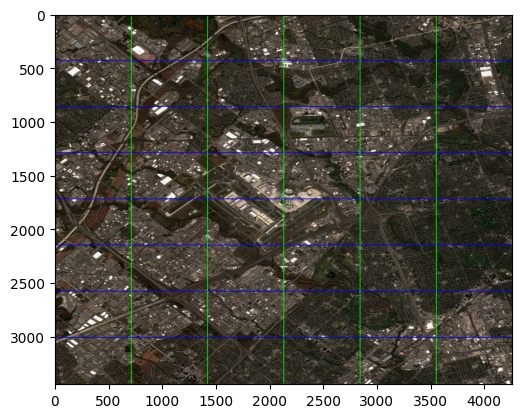

In [7]:
# a rareplanes image to test 
# im = cv2.imread("/content/Adelaide_Airport_0_0_101.png")

# challenge image 
im = cv2.imread("./img.tiff")

# scale 
scale_percent = 200 # percent of original size
width = int(im.shape[1] * scale_percent / 100)
height = int(im.shape[0] * scale_percent / 100)
dim = (width, height)
im = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
im_v = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
print(im.shape)

# subdivide so my laptop can handle prediction 
height, width, channels = im.shape
h_s = height // 8
w_s = width // 6

f = open("data_detector2.csv", "a")
for i in range(0, 8):
  for j in range(0,6):
    start_point = (w_s *j, 0)
    end_point = (w_s*j, height)
    start_point2 = (0, h_s*i)
    end_point2 = (width, h_s*i)
    color = (0, 255, 0)
    color2 = (255, 0, 0)
    thickness = 6
    image = cv2.line(im_v, start_point, end_point, color, thickness)
    image = cv2.line(im_v, start_point2, end_point2, color2, thickness)

# plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.imshow(cv2.cvtColor(im_v, cv2.COLOR_BGR2RGB))



In [8]:
# Create config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.MODEL.WEIGHTS = "./model_0024999.pth"


In [11]:
## helper function for cvs
scale = 2
def box_to_cvs(f, np_class, np_score, np_box, offset_x, offset_y):
  x1 = int(np_box[0]) + offset_x
  y1 = int(np_box[1]) + offset_y
  x2 = int(np_box[2]) + offset_x
  y2 = int(np_box[3]) + offset_y
  f_str = f"{np_class},{np_score},{x1/scale},{y1/scale},{x2/scale},{y2/scale}\n"
  print(f_str)
  f.write(f_str)

# Create predictor
predictor = DefaultPredictor(cfg)

# Make prediction
height, width, channels = im.shape
print(im.shape)
h_ = height // 8
w_ = width // 6
print(h_, w_)
f = open("data_detector2.csv", "a")
for i in range(0, 8):
  for j in range(0,6):
    section = im[h_*i:h_*(i+1), w_*j:w_*(j+1)]
    print(section.shape)
    outputs = predictor(section)
    boxes = outputs["instances"].pred_boxes.to("cpu")
    np_scores = outputs["instances"].scores.to("cpu").numpy()
    np_classes = outputs["instances"].pred_classes.to("cpu").numpy()
    index = 0
    for b in boxes:
      np_box = b.to("cpu").numpy()
      box_to_cvs(f,np_classes[index],np_scores[index],np_box,w_*j, h_*i )
      index = index + 1
    # visualize data:
    #v = Visualizer(section[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=2)
    #v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #plt.figure(figsize = (7, 5))
    #plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

f.close()

[12/03 14:36:40 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./model_0024999.pth ...
(3444, 4264, 3)
430 710
(430, 710, 3)
0,0.9555778503417969,346.0,122.5,353.5,128.0

0,0.9006257057189941,143.0,104.5,151.0,110.0

(430, 710, 3)
(430, 710, 3)
(430, 710, 3)
(430, 710, 3)
(430, 710, 3)
0,0.9592434763908386,1936.5,0.0,1943.5,3.5

(430, 710, 3)
0,0.9711615443229675,322.5,422.0,330.5,429.0

(430, 710, 3)
(430, 710, 3)
(430, 710, 3)
(430, 710, 3)
(430, 710, 3)
(430, 710, 3)
(430, 710, 3)
0,0.9464664459228516,424.5,493.0,433.0,498.0

(430, 710, 3)
0,0.8353636264801025,833.5,593.5,841.5,601.0

(430, 710, 3)
(430, 710, 3)
(430, 710, 3)
(430, 710, 3)
0,0.767225444316864,165.5,782.5,175.5,788.5

(430, 710, 3)
0,0.9471830129623413,373.0,797.0,380.0,803.0

0,0.824184775352478,482.0,674.5,490.5,681.0

(430, 710, 3)
0,0.8377645015716553,1003.0,835.5,1010.5,840.0

(430, 710, 3)
0,0.9970430731773376,1202.0,816.0,1209.5,823.0

(430, 710, 3)
(430, 710, 3)
(430, 710, 3)
(430, 